In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [5]:
inputdata= pd.read_csv('../data/processed/inputdata.csv')

In [22]:
attack_col=['x_Attack_01','y_Attack_01','s_Attack_01','dbf_Attack_01',
            'x_Attack_02','y_Attack_02','s_Attack_02','dbf_Attack_02',
            'x_Attack_03','y_Attack_03','s_Attack_03','dbf_Attack_03',
            'x_Attack_04','y_Attack_04','s_Attack_04','dbf_Attack_04',
            'x_Attack_05','y_Attack_05','s_Attack_05','dbf_Attack_05',
            'x_Attack_06','y_Attack_06','s_Attack_06','dbf_Attack_06', 
            'x_Attack_07','y_Attack_07','s_Attack_07','dbf_Attack_07',
            'x_Attack_08','y_Attack_08','s_Attack_08','dbf_Attack_08',
            'x_Attack_09','y_Attack_09','s_Attack_09','dbf_Attack_09',
            'x_Attack_10','y_Attack_10','s_Attack_10','dbf_Attack_10',
            'x_Attack_11','y_Attack_11','s_Attack_11','dbf_Attack_11'        
           
           ]

defense_col=['x_Defense_01','y_Defense_01','s_Defense_01','dbf_Defense_01',
             'x_Defense_02','y_Defense_02','s_Defense_02','dbf_Defense_02',
             'x_Defense_03','y_Defense_03','s_Defense_03','dbf_Defense_03',
             'x_Defense_04','y_Defense_04','s_Defense_04','dbf_Defense_04',
             'x_Defense_05','y_Defense_05','s_Defense_05','dbf_Defense_05',
             'x_Defense_06','y_Defense_06','s_Defense_06','dbf_Defense_06', 
             'x_Defense_07','y_Defense_07','s_Defense_07','dbf_Defense_07',
             'x_Defense_08','y_Defense_08','s_Defense_08','dbf_Defense_08',
             'x_Defense_09','y_Defense_09','s_Defense_09','dbf_Defense_09',
             'x_Defense_10','y_Defense_10','s_Defense_10','dbf_Defense_10',
             'x_Defense_11','y_Defense_11','s_Defense_11','dbf_Defense_11'
            ]

In [23]:
inputdata[attack_col+defense_col].dropna(axis=0).shape

(279015, 88)

In [24]:
inputdata= inputdata[['time','gameId','playId']+attack_col+defense_col]
inputdata.dropna(axis=0,inplace=True)

In [25]:
def data_proc(data,seq_ln,forecast_ln):
    X=[]
    Y=[]
    
    start=0
    end= seq_ln
    forecast_end= seq_ln+forecast_ln    
    
    for n in range(data.shape[0]- (seq_ln+forecast_ln)):
        
        values=data.values
        X.append(values[start:end].tolist())
        Y.append(values[end:forecast_end].tolist())
        
        start+=1
        end+=1
        forecast_end+=1
        
    #X= np.reshape(X,(data.shape[0],seq_ln,1))
    #Y= np.reshape(Y,(data.shape[0],forecast_ln,1))  
    return X,Y

In [54]:
in_len=2
out_len=30
offense_past=[]
offense_next =[]

for gameid in inputdata.gameId.unique().tolist():
    for playid in inputdata.playId.unique().tolist():
        
        offense_sq=inputdata[(inputdata['gameId']==gameid)&(inputdata['playId']==playid)][attack_col]
        x,y= data_proc(offense_sq,in_len,out_len)
        
        offense_past.append(x)
        offense_next.append(y)



#defense_sq= inputdata[defense_col]
#defense_past30, defense_next10= data_proc(defense_sq,30,10)

In [55]:
len(offense_past[0])

3

In [56]:

defense_past=[]
defense_next =[]

for gameid in inputdata.gameId.unique().tolist():
    for playid in inputdata.playId.unique().tolist():
        
        defense_sq=inputdata[(inputdata['gameId']==gameid)&(inputdata['playId']==playid)][defense_col]
        x,y= data_proc(defense_sq,in_len,out_len)
        defense_past.append(x)
        defense_next.append(y)



#defense_sq= inputdata[defense_col]
#defense_past30, defense_next10= data_proc(defense_sq,30,10)

In [57]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [58]:
offense_past= flatten(offense_past)
offense_next =flatten(offense_next)

defense_past= flatten(defense_past)
defense_next =flatten(defense_next)


In [59]:
offense_past= np.array(offense_past)
offense_next =np.array(offense_next)

defense_past= np.array(defense_past)
defense_next =np.array(defense_next)

In [60]:
offense_past.shape,defense_past.shape

((39423, 2, 44), (39423, 2, 44))

In [61]:
offense_defense_past =np.ones((offense_past.shape[0],offense_past.shape[1],offense_past.shape[2]+defense_past.shape[2]))
for c in range(offense_past.shape[0]):
    for t in range(offense_past.shape[1]):
        offense_defense_past[c][t]= np.append(offense_past[c][t],defense_past[c][t])
        
offense_defense_past.shape



(39423, 2, 88)

In [62]:
defence_target= np.ones((defense_next.shape[0],defense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(defense_next.shape[0]):
    for t in range(defense_next.shape[1]):
        defence_target[c][t]= defense_next[c][t][a]
defence_target.shape

(39423, 30, 22)

In [63]:
from sklearn.model_selection import train_test_split


In [64]:
test_len= int(0.9*offense_defense_past.shape[0])
test_len

35480

In [65]:
x_train_val= offense_defense_past[:test_len]
x_test= offense_defense_past[test_len:]

y_train_val = defence_target[:test_len]
y_test= defence_target[test_len:]


In [66]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, random_state=0, train_size = .8)


In [67]:
x_train.shape, x_test.shape,x_val.shape

((28384, 2, 88), (3943, 2, 88), (7096, 2, 88))

In [68]:
y_train.shape, y_test.shape,y_val.shape

((28384, 30, 22), (3943, 30, 22), (7096, 30, 22))

In [69]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [70]:
epochs = 50
batch_size = 32
validation = 0.1
callback = EarlyStopping(monitor='loss', patience=3)

In [71]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(200, activation='relu', 
                    input_shape=(x_train.shape[1],x_train.shape[2])))
LSTM_model.add(RepeatVector(y_train.shape[1]))
LSTM_model.add(LSTM(200, activation='relu', return_sequences=True))
LSTM_model.add(TimeDistributed(Dense(100, activation='relu')))
LSTM_model.add(TimeDistributed(Dense(y_train.shape[2])))
LSTM_model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               231200    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 200)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 200)           320800    
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 100)          20100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 22)           2222      
 tributed)                                                       
                                                      

In [72]:
LSTM_history=LSTM_model.fit(x_train,y_train,batch_size=10,epochs=100,validation_data=(x_val,y_val),callbacks=[callback])


Epoch 1/100
2839/2839 [==============================] - 73s 25ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 2/100
2839/2839 [==============================] - 76s 27ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/100
2839/2839 [==============================] - 80s 28ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
2839/2839 [==============================] - 83s 29ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
2839/2839 [==============================] - 86s 30ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
2839/2839 [==============================] - 88s 31ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
2839/2839 [==============================] - 87s 31ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
2839/2839 [==============================] - 90s 32ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
2839/2839 [==============================] - 90s 32ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
2839/2839 [==============================]

2839/2839 [==============================] - 151s 53ms/step - loss: 4.8639e-04 - val_loss: 5.7183e-04
Epoch 75/100
2839/2839 [==============================] - 152s 54ms/step - loss: 4.8033e-04 - val_loss: 5.3827e-04
Epoch 76/100
2839/2839 [==============================] - 153s 54ms/step - loss: 4.7834e-04 - val_loss: 5.1229e-04
Epoch 77/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.7197e-04 - val_loss: 5.0438e-04
Epoch 78/100
2839/2839 [==============================] - 152s 53ms/step - loss: 4.6804e-04 - val_loss: 5.4878e-04
Epoch 79/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.6364e-04 - val_loss: 5.2790e-04
Epoch 80/100
2839/2839 [==============================] - 149s 52ms/step - loss: 4.5949e-04 - val_loss: 4.8346e-04
Epoch 81/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.5603e-04 - val_loss: 4.9635e-04
Epoch 82/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.5047e-04 -

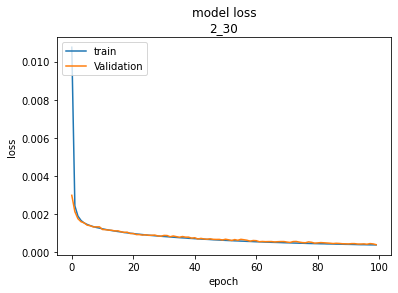

In [73]:
# summarize history for loss
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('model loss\n'+str(in_len)+'_'+str(out_len))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [74]:
predictions=LSTM_model.predict(x_test)

124/124 [==============================] - 2s 14ms/step


In [75]:
predictions.shape

(3943, 30, 22)

In [76]:
np.corrcoef((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train))))[0,1]**2

887/887 [==============================] - 14s 16ms/step


0.9783749607714434

In [77]:
np.corrcoef((flatten(flatten(y_test))),flatten(flatten(predictions)))[0,1]**2

0.9013742890337167

In [78]:
from sklearn.metrics import r2_score 
print("R-Square value from train: ",r2_score((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train)))))
print("max deviation train: ",max(np.subtract((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train))))))

print("R-Square value from val: ",r2_score((flatten(flatten(y_val))),flatten(flatten(LSTM_model.predict(x_val)))))
print("max deviation val: ",max(np.subtract((flatten(flatten(y_val))),flatten(flatten(LSTM_model.predict(x_val))))))

print("R-Square value from test: ",r2_score((flatten(flatten(y_test))),flatten(flatten(LSTM_model.predict(x_test)))))
print("max deviation test: ",max(np.subtract((flatten(flatten(y_test))),flatten(flatten(LSTM_model.predict(x_test))))))


887/887 [==============================] - 14s 16ms/step
R-Square value from train:  0.9782397133089553
887/887 [==============================] - 15s 16ms/step
max deviation train:  0.2631794739031923
222/222 [==============================] - 4s 16ms/step
R-Square value from val:  0.9755373755109801
222/222 [==============================] - 4s 16ms/step
max deviation val:  0.25737544350053976
124/124 [==============================] - 2s 16ms/step
R-Square value from test:  0.900670748297303
124/124 [==============================] - 2s 16ms/step
max deviation test:  0.36752173242893305


In [79]:
LSTM_model.save('E:/1014/NFL_Analysis/Simulation_models/New_model/model_'+str(in_len)+'_'+str(out_len))

INFO:tensorflow:Assets written to: E:/1014/NFL_Analysis/Simulation_models/New_model/model_2_30\assets


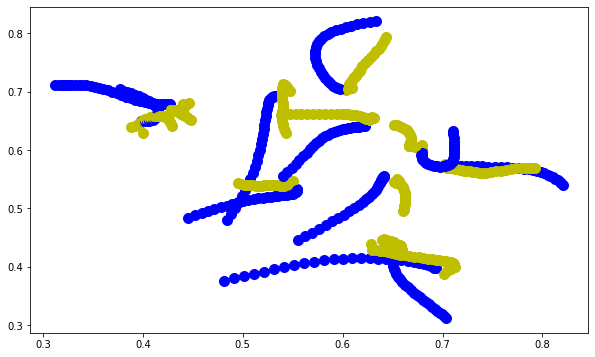

In [80]:
n=1

fig, ax = plt.subplots(figsize=(10, 6))

for t in range(30):
    for player in range(11):
        ax.scatter(predictions[n][t][player],predictions[n][t][player+1],c='y',s=100)
        ax.scatter(y_test[n][t][player],y_test[n][t][player+1],c='b',s=100)
        
  

In [ ]:
plt.scatter((flatten(flatten(y_test))),flatten(flatten(model_enc_dec_cnn.predict(x_test))))

In [ ]:
plt.scatter(flatten(y_test[:,4,:]),flatten(predictions[:,4,:]))

In [112]:
import seaborn as sns


<AxesSubplot:ylabel='Count'>

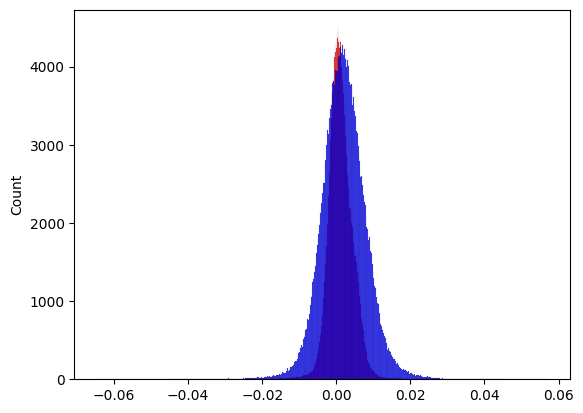

In [113]:
error= np.subtract(flatten(y_test[:,0,:]),flatten(predictions[:,0,:]))
sns.histplot(error,color='red')
sns.histplot(np.subtract(flatten(y_test[:,4,:]),flatten(predictions[:,4,:])),color='blue')

In [116]:
y_test.shape

(10929, 10, 22)

In [117]:
error_step1= np.subtract(flatten(y_test[:,0,:]),flatten(predictions[:,0,:]))
error_step2= np.subtract(flatten(y_test[:,2,:]),flatten(predictions[:,2,:]))
error_step3= np.subtract(flatten(y_test[:,4,:]),flatten(predictions[:,4,:]))
error_step4= np.subtract(flatten(y_test[:,6,:]),flatten(predictions[:,6,:]))
error_step5= np.subtract(flatten(y_test[:,8,:]),flatten(predictions[:,8,:]))


C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
C:\study_tools\envs\DL\lib\site

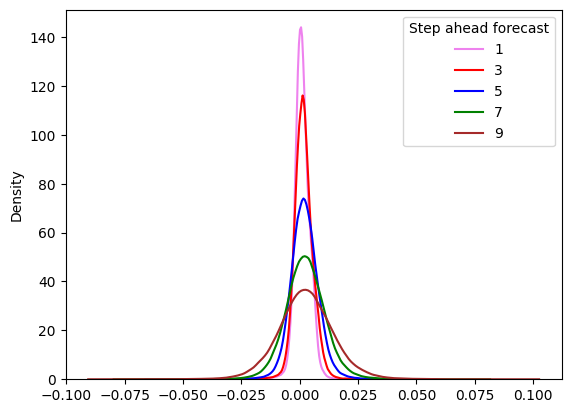

In [119]:

sns.distplot(error_step1,color='violet',hist=False,label='1')
sns.distplot(error_step2,color='red',hist=False,label='3')
sns.distplot(error_step3,color='blue',hist=False,label='5')
sns.distplot(error_step4,color='green',hist=False,label='7')
sns.distplot(error_step5,color='brown',hist=False,label='9')

plt.legend(title="Step ahead forecast")
plt.show()